In [1]:
import xarray as xr
from pathlib import Path

import sys
sys.path.append(str(Path("../").expanduser().resolve()))

import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional
from st_encoder_decoder import SpatioTemporalModel, prepare_spatiotemporal_batch, pred_to_numpy

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Read data

In [3]:
data_folder = Path("~/temp/eso4clima/")

file_name = data_folder / "202001_day_ERA5_masked_ts.nc"
daily_data = xr.open_dataset(file_name)

file_name = data_folder / "202001_mon_ERA5_full_ts.nc"
monthly_data = xr.open_dataset(file_name)

file_name = data_folder / "era5_lsm_bool.nc"  # downloded from era5 and regridded using the function `regrid_to_boundary_centered_grid`
lsm_mask = xr.open_dataset(file_name)

## Subset data (for fast example)

In [4]:
# coordinates of subset
lon_subset = slice(-50, -10)
lat_subset = slice(-40, -20)

daily_subset = daily_data.sel(lon=lon_subset, lat=lat_subset)
monthly_subset = monthly_data.sel(lon=lon_subset, lat=lat_subset)
lsm_subset = lsm_mask.sel(longitude=lon_subset, latitude=lat_subset)

## Create the model

In [5]:
model = SpatioTemporalModel(embed_dim=128, patch_size=(1, 2, 2), overlap=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [6]:
# prepare the data
batch = prepare_spatiotemporal_batch(daily_subset["ts"].values, monthly_subset["ts"].values, lsm_subset["lsm"].values, patch_size=model.patch_size)
daily_ts = batch["daily_data"]
daily_mask = batch["daily_mask"]
monthly_ts = batch["monthly_target"]
land_mask = batch["land_mask"]

print(daily_ts.shape, daily_mask.shape, monthly_ts.shape, land_mask.shape)

torch.Size([1, 1, 31, 80, 160]) torch.Size([1, 1, 31, 80, 160]) torch.Size([1, 80, 160]) torch.Size([80, 160])


In [7]:
# initialize decoder
decoder = model.decoder 

# set scale and bias
decoder.bias.data.fill_(monthly_ts.mean())
decoder.scale.data.fill_(monthly_ts.std() + 1e-6) # small epsilon to avoid zero

tensor([3.3376])

## Train the model

In [8]:
best_loss = float("inf")
patience = 10           # stop if no improvement for <patience> epochs
counter = 0

# training loop
model.train()
for epoch in range(201):
    optimizer.zero_grad()
    pred = model(daily_ts, daily_mask, land_mask)  # pred: (B, H', W')
    # Mask out land pixels
    ocean = ~land_mask  # ocean=True
    loss = torch.nn.functional.l1_loss(pred[0][ocean], monthly_ts[0][ocean])
    loss.backward()
    optimizer.step()
    
    # Early stopping check
    if loss.item() < best_loss:
        best_loss = loss.item()
        counter = 0       # reset counter if improved
    if epoch % 20 == 0:
        print(f"The loss is {best_loss} at epoch {epoch}")
    else:
        counter += 1
        if counter >= patience:
            print(f"No improvement for {patience} epochs, stopping early at epoch {epoch}.")
            break

print("training done!")
print(loss.item())

The loss is 3.011814594268799 at epoch 0
The loss is 0.8889213800430298 at epoch 20
The loss is 0.6553868651390076 at epoch 40
The loss is 0.5312679409980774 at epoch 60
The loss is 0.4426269829273224 at epoch 80
The loss is 0.3747095763683319 at epoch 100
The loss is 0.3276576101779938 at epoch 120
The loss is 0.2547023296356201 at epoch 140
The loss is 0.2074669599533081 at epoch 160
No improvement for 10 epochs, stopping early at epoch 175.
training done!
0.19536009430885315


## Inspect results and compare

In [9]:
monthly_prediction = pred_to_numpy(pred, land_mask=land_mask)
monthly_subset["ts_pred"] = (
    ("time", "lat", "lon"),
    monthly_prediction
)

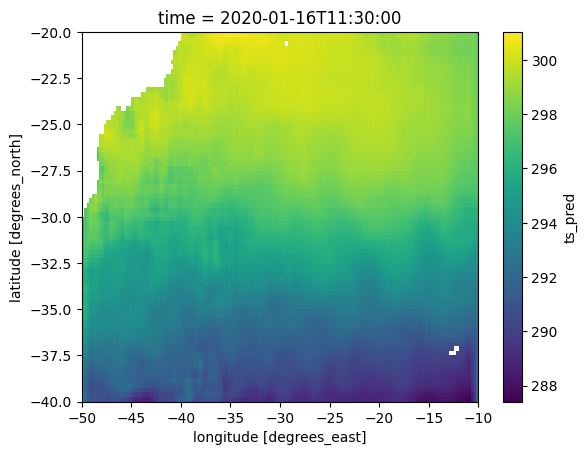

In [10]:
monthly_subset["ts_pred"].plot()

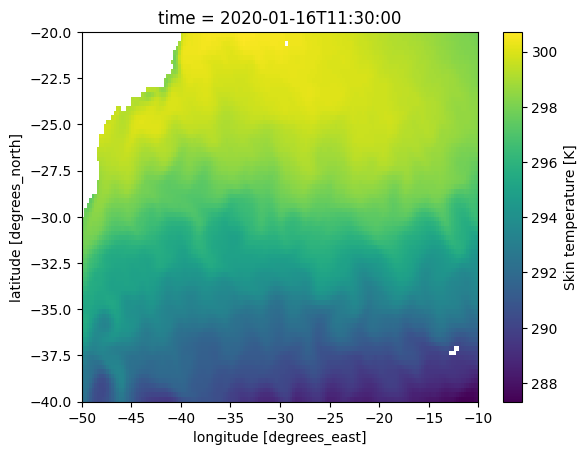

In [11]:
# original target
monthly_subset["ts"].where(~lsm_subset["lsm"].values).plot()